## Calculating attention in BERT

In this notebook we calculate the attention weights on subject and object for ruBERT model

In [71]:
import pandas as pd
import torch
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests

from transformers import AutoModel, AutoTokenizer, AutoConfig

In [72]:
def decode_tokens(example):
    idx = 1
    enc =[(x, tokenizer.encode(x, add_special_tokens=False)) for x in example.split()]

    desired_output = []

    for x, token in enc:
        tokenoutput = []
        for ids in token:
            tokenoutput.append(idx)
            idx +=1
        desired_output.append(tokenoutput)

    return desired_output

In [73]:
def get_attention_scores(
    sentence:str,
    attention,
    subj:int = 0,
    obj:int = 2,
    verb_b:int = 3,
    verb_e:int = 5
):
    words = decode_tokens(sentence)
    subj_word = words[subj]
    obj_word = words[obj]
    verb = [idx for x in words[verb_b:verb_e] for idx in x]

    subj_attention = attention[:,verb[0]:verb[-1]+1,subj_word[0]:subj_word[-1]+1].mean(axis=[1,2])
    obj_attention = attention[:,verb[0]:verb[-1]+1,obj_word[0]:obj_word[-1]+1].mean(axis=[1,2])

    return subj_attention, obj_attention

In [74]:
def return_batch_attention(sentences, attentions, emb_size=12):
    subj_att_weights = torch.zeros(len(sentences), emb_size)
    obj_att_weights = torch.zeros(len(sentences), emb_size)
    for num, (sentence, attention) in enumerate(zip(sentences, attentions)):
        subj_W, obj_W = get_attention_scores(sentence, attention)
        subj_att_weights[num] = subj_W
        obj_att_weights[num] = obj_W
    return subj_att_weights, obj_att_weights

We use ruBERT model developed by DeepPavlov:

In [75]:
MODEL_NAME = "DeepPavlov/rubert-base-cased"

model = AutoModel.from_pretrained(MODEL_NAME, output_attentions=True)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
device = "cpu"

model = model.to(device)

In [76]:
stimuli = pd.read_csv("stimuli (1).xlsx - Sl2018_JML.csv")
sentences = stimuli.Sentence.to_list()
data_loader = torch.utils.data.DataLoader(sentences, batch_size=4)

Here we calculate attention weights:

In [80]:
subj_predictions = []
obj_predictions = []
for sent_batch in tqdm(data_loader):
    enc = tokenizer(sent_batch, padding=True, truncation=True,
                max_length=512, return_tensors='pt')
    with torch.no_grad():
        enc = enc.to(device)
        output = model(**enc, return_dict=True)
        subj, obj = return_batch_attention(sent_batch, output["attentions"][-1])
        subj_predictions.append(subj)
        obj_predictions.append(obj)

  0%|          | 0/128 [00:00<?, ?it/s]

In [81]:
subj_attention = torch.cat(subj_predictions)
obj_attention = torch.cat(obj_predictions)

In [82]:
sss = stimuli.index[stimuli['Code'] == 'S_S-S'].tolist()
pss = stimuli.index[stimuli['Code'] == 'P_S-S'].tolist()
ssp = stimuli.index[stimuli['Code'] == 'S_S-P'].tolist()
sps = stimuli.index[stimuli['Code'] == 'S_P-S'].tolist()
pps = stimuli.index[stimuli['Code'] == 'P_P-S'].tolist()
spp = stimuli.index[stimuli['Code'] == 'S_P-P'].tolist()
ppp = stimuli.index[stimuli['Code'] == 'P_P-P'].tolist()
psp = stimuli.index[stimuli['Code'] == 'P_S-P'].tolist()

Text(0.5, 1.0, 'P_P-S')

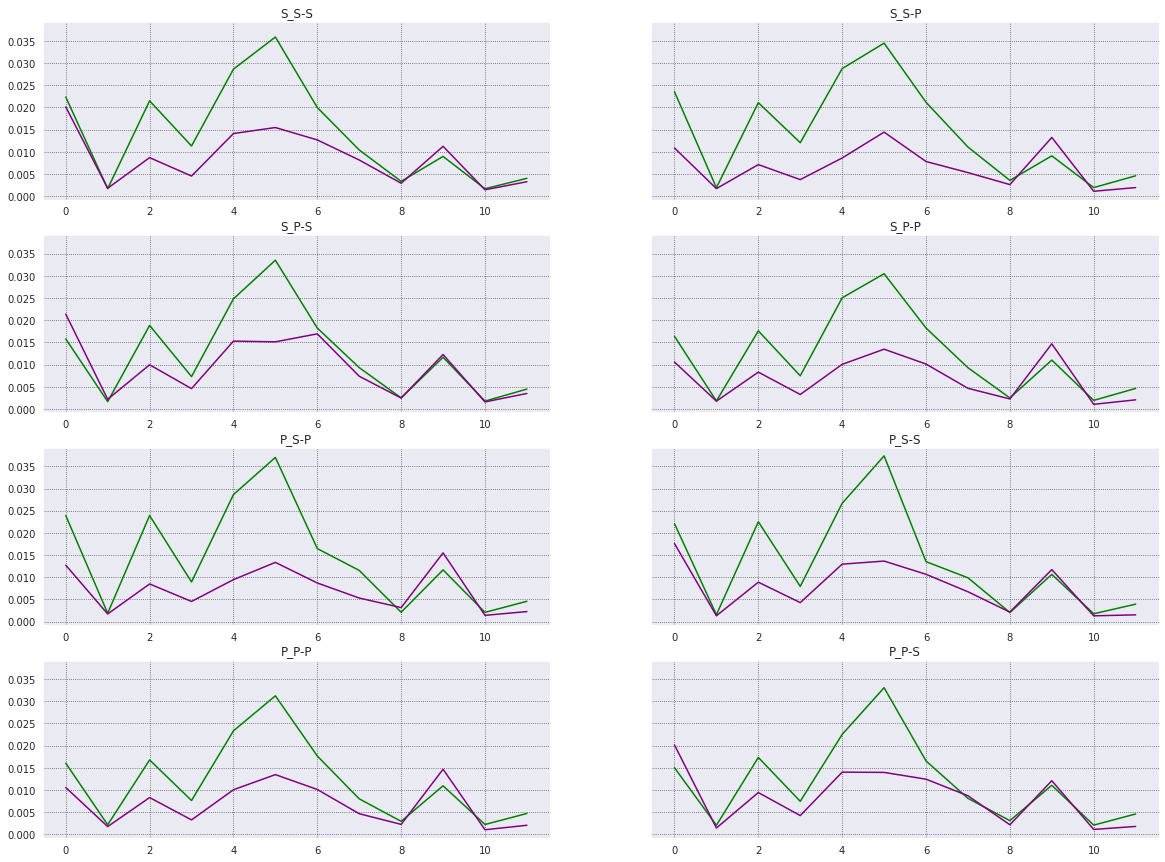

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".3", "grid.linestyle": ":"})
sns.color_palette("mako", as_cmap=True)

fig, ax = plt.subplots(4, 2, figsize=(20, 15), sharey=True)

sns.lineplot(subj_attention[sss].mean(axis=0), ax=ax[0,0], color="green", legend="auto")
sns.lineplot(obj_attention[sss].mean(axis=0), ax=ax[0,0], color="purple", legend="auto")
ax[0,0].set_title('S_S-S')

sns.lineplot(subj_attention[ssp].mean(axis=0), ax=ax[0,1], color="green")
sns.lineplot(obj_attention[ssp].mean(axis=0), ax=ax[0,1], color="purple")
ax[0,1].set_title('S_S-P')

sns.lineplot(subj_attention[sps].mean(axis=0), ax=ax[1,0], color="green")
sns.lineplot(obj_attention[sps].mean(axis=0), ax=ax[1,0], color="purple")
ax[1,0].set_title('S_P-S')

sns.lineplot(subj_attention[spp].mean(axis=0), ax=ax[1,1], color="green")
sns.lineplot(obj_attention[spp].mean(axis=0), ax=ax[1,1], color="purple")
ax[1,1].set_title('S_P-P')

sns.lineplot(subj_attention[psp].mean(axis=0), ax=ax[2,0], color="green")
sns.lineplot(obj_attention[psp].mean(axis=0), ax=ax[2,0], color="purple")
ax[2,0].set_title('P_S-P')

sns.lineplot(subj_attention[pss].mean(axis=0), ax=ax[2,1], color="green")
sns.lineplot(obj_attention[pss].mean(axis=0), ax=ax[2,1], color="purple")
ax[2,1].set_title('P_S-S')

sns.lineplot(subj_attention[ppp].mean(axis=0), ax=ax[3,0], color="green")
sns.lineplot(obj_attention[spp].mean(axis=0), ax=ax[3,0], color="purple")
ax[3,0].set_title('P_P-P')

sns.lineplot(subj_attention[pps].mean(axis=0), ax=ax[3,1], color="green")
sns.lineplot(obj_attention[pps].mean(axis=0), ax=ax[3,1], color="purple")
ax[3,1].set_title('P_P-S')


In [84]:
stimuli["subj_attention"] = subj_attention.tolist()
stimuli["obj_attention"] = obj_attention.tolist()

In [85]:
stimuli.to_csv(f"raw_results/results_{MODEL_NAME.split('/')[-1]}.csv")

In [38]:
from scipy.stats import ttest_rel
cases = {"S_S-S": sss,
                "S_P-S": sps,
                "S_S-P": ssp,
                "S_P-P": spp,
                "P_S-S": pss,
                "P_P-S": pps,
                "P_S-P": psp,
                "P_P-P": ppp}

Comparison of different conditions:

In [69]:
from itertools import combinations

For subject:

In [70]:
pvals = []
names = []
for case_1, case_2 in combinations(cases.items(), 2):
    res = ttest_rel(subj_attention[case_1[1]].mean(0), subj_attention[case_2[1]].mean(0))
    pvals.append(res.pvalue)
    names.append(f"{case_1[0]} - {case_2[0]}")

In [71]:
pvals = multipletests(pvals, method="bonferroni")

In [72]:
import pandas as pd

subj_attention = pd.DataFrame({"comparison": names, "p-value": pvals[1], "significant": pvals[0]})
subj_attention.to_csv(f"scores/{MODEL_NAME.split('/')[-1]}_subj_attention.csv")

For object:

In [74]:
pvals = []
names = []

for case_1, case_2 in combinations(cases.items(), 2):
    res = ttest_rel(obj_attention[case_1[1]].mean(0), obj_attention[case_2[1]].mean(0))
    pvals.append(res.pvalue)
    names.append(f"{case_1[0]} - {case_2[0]}")

In [75]:
pvals = multipletests(pvals, method="bonferroni")
obj_attention = pd.DataFrame({"comparison": names, "p-value": pvals[1], "significant": pvals[0]})
obj_attention.to_csv(f"scores/{MODEL_NAME.split('/')[-1]}_obj_attention.csv")